# **PREMISE**

Playing around with Cassava Data. Getting comfortab;e with FastAI.

## IMPORTS

In [1]:
from fastai.vision.all import *
import pandas as pd

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(21)

## DATASET EXPLORATION

In [3]:
df = pd.read_csv("wandb_cassava_train_val_split.csv")
df.head()

,image_id,label,is_val
0,1000015157.jpg,0,False
1,1000201771.jpg,3,False
2,100042118.jpg,1,False
3,1000723321.jpg,1,False
4,1000812911.jpg,3,False


There are 5 labels (4 diseases and healthy):

0. Cassava Bacterial Blight (CBB)
1. Cassava Brown Streak Disease (CBSD)
2. Cassava Green Mottle (CGM)
3. Cassava Mosaic Disease (CMD)
4. Healthy

<AxesSubplot:>

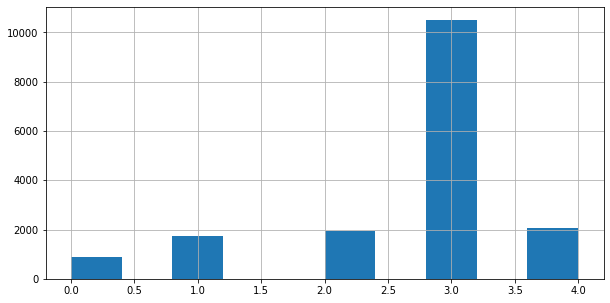

In [4]:
df.loc[~df['is_val']]['label'].hist(figsize=(10,5))

Contrary to my thoughts, `Healthy` images were lesser than the ones with diseases.While it makes most sense to train with all five classes at once, I decided to use the imbalance to create a stacked model.  

My workflow will be as below:
- `model_3`: This will be a two class model which will categorize if the image is of the Cassava Mosaic Disease (CMD) or others.
- `model_others`: This will be trained with all image data other than the ones belonging to Class-3.  

In [5]:
df["model3_lab"] = df['label'].apply(lambda x:1 if x == 3 else 0)
df.head()

,image_id,label,is_val,model3_lab
0,1000015157.jpg,0,False,0
1,1000201771.jpg,3,False,1
2,100042118.jpg,1,False,0
3,1000723321.jpg,1,False,0
4,1000812911.jpg,3,False,1


## MODELLING

### Helper Functions

In [6]:
path = Path()

def get_x(row):
    return path/'data'/'train_images'/row['image_id']

def get_y(row, model3=False):
    return row['model3_lab'] if model3 else row['label']

In [7]:
def splitter(df, model3=False):
    select_cols = df['label'].unique().tolist() if model3 else [0]
    train = df.index[(~df['is_val']) & (df['model3_lab'].isin(select_cols))].tolist()
    valid = df.index[(df['is_val']) & (df['model3_lab'].isin(select_cols))].tolist()
    return train, valid

### The first model: `model_3`

#### Creating Dataset

In [8]:
model3_cassava = DataBlock( 
                                blocks= (ImageBlock, CategoryBlock),
                                get_x=get_x,
                                get_y=lambda x:get_y(x, model3=True),
                                splitter=lambda x:splitter(x,model3=True),
                                item_tfms=Resize(460),
                                batch_tfms=aug_transforms(size=224, min_scale=0.75)
                          )

dls_model3 = model3_cassava.dataloaders(df)

/home/ubuntu/alpha2icon/AlphaClassify_v2/fastalpha/lib/python3.6/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


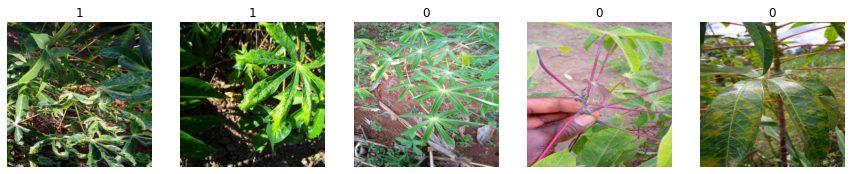

In [9]:
dls_model3.show_batch(nrows=1, ncols=5)

#### Learning

The new LR find makes finding OOTB learning rates even more easier. More on this can be seen in [this](https://forums.fast.ai/t/new-lr-finder-output/89236/3) thread.  

I am yet to understand this in detail. So training pipeline is from Ravi Mashru's notebook.

In [10]:
m3_learn = cnn_learner(dls_model3, resnet34, metrics=accuracy)

/home/ubuntu/alpha2icon/AlphaClassify_v2/fastalpha/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch,train_loss,valid_loss,accuracy,time
0,0.488375,0.349680,0.851835,02:23
1,0.323432,0.279693,0.887824,02:21
2,0.285131,0.272405,0.888058,02:19


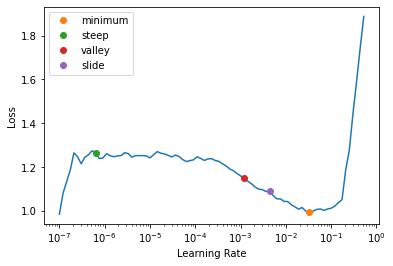

In [11]:
lr_min, lr_steep, lr_valley, lr_slide = m3_learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
m3_learn.fit_one_cycle(3, lr_valley.item())

In [12]:
m3_learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time
0,0.287242,0.271028,0.888993,02:25
1,0.272648,0.270186,0.887824,02:25
2,0.266783,0.269084,0.887824,02:25
3,0.272453,0.267913,0.888525,02:25
4,0.265764,0.268119,0.890395,02:26


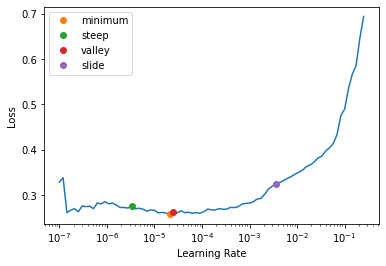

In [14]:
lr_min, lr_steep, lr_valley, lr_slide = m3_learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
m3_learn.fit_one_cycle(5, lr_max=slice(0.1*lr_min, lr_min))

### The second model: `model_others`

#### Creating Dataset

In [15]:
model_others_cassava = DataBlock( 
                                blocks= (ImageBlock, CategoryBlock),
                                get_x=get_x,
                                get_y=lambda x:get_y(x, model3=False),
                                splitter=lambda x:splitter(x,model3=False),
                                item_tfms=Resize(460),
                                batch_tfms=aug_transforms(size=224, min_scale=0.75)
                          )

dls_others = model_others_cassava.dataloaders(df)

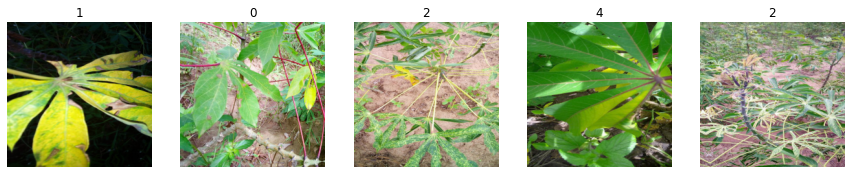

In [16]:
dls_others.show_batch(nrows=1, ncols=5)

#### Learning

In [17]:
others_learn = cnn_learner(dls_others, resnet34, metrics=accuracy)

epoch,train_loss,valid_loss,accuracy,time
0,1.570635,1.076016,0.607975,00:55
1,1.170932,0.891429,0.648466,00:54
2,1.006410,0.856741,0.662577,00:54


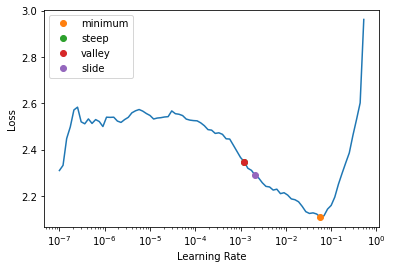

In [18]:
lr_min, lr_steep, lr_valley, lr_slide = others_learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
# Using valley blindly!
others_learn.fit_one_cycle(3, lr_valley.item())

In [19]:
others_learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time
0,0.951911,0.846176,0.672393,00:56
1,0.930399,0.825522,0.684663,00:57
2,0.874135,0.793528,0.690184,00:56
3,0.805947,0.775917,0.696932,00:56
4,0.738774,0.779738,0.701841,00:56
5,0.692332,0.768470,0.708589,00:56
6,0.644364,0.764450,0.709202,00:57
7,0.623988,0.771932,0.707362,00:56
8,0.591409,0.772930,0.714110,00:56
9,0.564952,0.771398,0.713497,00:56


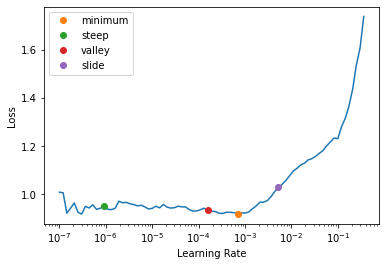

In [20]:
lr_min, lr_steep, lr_valley, lr_slide = others_learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
others_learn.fit_one_cycle(12, lr_max=slice(0.1*lr_min, lr_min))

## VALIDATION

### Inferencing the two models

_There must be an easier way to do this! Would appreciate some pointeres here!_

In [21]:
from sklearn.metrics import accuracy_score

##### First model inference

In [22]:
test_df = df[df['is_val']]

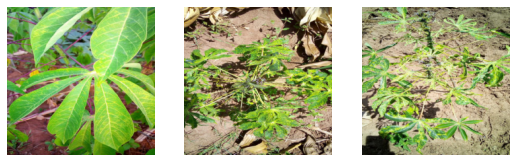

In [23]:
test_dl = dls_model3.test_dl(test_df)
test_dl.show_batch(nrows=1,ncols=3)

In [24]:
outputs = m3_learn.get_preds(dl=test_dl, with_input=True)

In [25]:
predicted_val = np.argmax(outputs[1], axis=1).cpu().numpy().tolist()
predicted_val = [m3_learn.dls.vocab[i] for i in predicted_val]
actual_val = test_df['model3_lab'].values.tolist()
accuracy_score(actual_val, predicted_val)

0.8903949520916102

In [26]:
test_df['m3_out'] = predicted_val

ipykernel_launcher:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


##### Second model inference 

Now sending only the images being predicted as 0 to the second model

In [27]:
test_others_df = test_df[test_df['m3_out'] == 0]

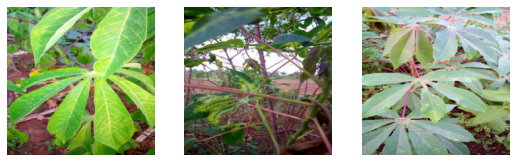

In [28]:
# test_others_df = test_df[(test_df['is_val']) & (test_df['m3_out'] == 0)]
test_dl = dls_model3.test_dl(test_others_df)
test_dl.show_batch(nrows=1,ncols=3)

In [29]:
outputs = others_learn.get_preds(dl=test_dl, with_input=True)

In [30]:
predicted_val = np.argmax(outputs[1], axis=1).cpu().numpy().tolist()
predicted_val = [others_learn.dls.vocab[i] for i in predicted_val]

In [31]:
actual_val = test_others_df['label'].values.tolist()
accuracy_score(actual_val, predicted_val)

0.6267372600926538

In [32]:
test_others_df['final_output'] = predicted_val

ipykernel_launcher:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [33]:
test_df.shape, test_others_df.shape

((4279, 5), (1511, 6))

### Creating the final Results

In [36]:
results_df = test_df.merge(test_others_df[["image_id", "final_output"]], on="image_id", how="left")
print (results_df.shape)

(4279, 6)


In [37]:
results_df.loc[results_df['final_output'].isnull(),'final_output'] = results_df['m3_out']*results_df['label']
results_df.head()

,image_id,label,is_val,model3_lab,m3_out,final_output
0,4081341161.jpg,1,True,0,0,1.0
1,408144068.jpg,3,True,1,1,3.0
2,4081836555.jpg,3,True,1,1,3.0
3,4082024517.jpg,3,True,1,0,1.0
4,4082420465.jpg,4,True,0,0,4.0


In [39]:
accuracy = accuracy_score(results_df['label'], results_df['final_output'])
print (f"Stack model accuracy is {accuracy*100:.2f}%")

Stack model accuracy is 86.82%


In [40]:
results_df.to_csv("cassava_results.csv", index=False)